# 07. In vivo MOC1 chronic IFN +/- Elf3 KO: bulk RNA-seq

WT or Elf3 KO MOC1 cells were treated with IFN-gamma or vehicle for 1 month, underwent a 2-week washout period, then were injected into the flanks of C57BL/6 mice. Tumors were treated with anti-PD1 ICI or IgG control, and allowed to grow until Day 30. Tumors were then dissected, sorted for CD45. CD45+ cells underwent flow cytometry analysis. CD45- cells were saved for RNA-seq. This data represents all CD45- cells, including malignant cells and small number of fibroblasts and endothelial cells.

In [1]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patheffects import withStroke
from adjustText import adjust_text
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import matplotlib as mpl

## 0. Read in and format counts

In [2]:
counts = pd.read_csv('/path/to/RSM020_counts.csv')
# label index as Geneid
counts = counts.rename(columns={'Unnamed: 0': 'Geneid'})
counts = counts.set_index('Geneid')

In [3]:
# keep only genes with >10 counts across samples
counts = counts[counts.sum(axis = 1) > 10]

In [4]:
# remove duplicated gene
counts.index[counts.index.duplicated()]
counts = counts[~counts.index.duplicated()]

In [5]:
# transpose for DESeq
counts = counts.T

In [6]:
# read in and format metadata
metadata = pd.read_csv('/path/to/counts_manifest.csv')
metadata = metadata.set_index('sample')
metadata = metadata[metadata.experiment == 'RSM020']
metadata = metadata.drop(columns=['experiment','mouse_ID'])

In [7]:
metadata.shape

(42, 1)

In [8]:
counts.shape

(42, 16729)

## Part 1. Perform DESeq to obtain normalized counts matrix

In [9]:
# initialize DEseq
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="condition")

In [10]:
# run DESeq
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 1.30 seconds.

Fitting dispersion trend curve...
... done in 0.27 seconds.

Fitting MAP dispersions...
... done in 1.67 seconds.

Fitting LFCs...
... done in 1.16 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 19 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [11]:
dds

AnnData object with n_obs × n_vars = 42 × 16729
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [12]:
# create size-factor normalized counts matrix
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

In [13]:
# These samples were both labeled RSM020-11. 
# Removing them because it is not obvious which one belongs in its group and 
# which one does not. RS42C_14 is an outlier for most analyses...removing as well.

metadata = metadata[~metadata.index.isin(['RS42C_6','RS42C_7','RS42C_14'])]
norm_counts = norm_counts[~norm_counts.index.isin(['RS42C_6','RS42C_7','RS42C_14'])]

In [14]:
# Generate an AnnData object
adata = sc.AnnData(norm_counts.iloc[:, 1:])
adata.obs = metadata

## Part 2. Score gene sets on anti-PD1-treated tumors (+/- Elf3 KO)

In [15]:
# define genesets
ICBres = [
    "Prss27", "Elf3", "Desi1", "Ltf", "Pglyrp4", "Pdzk1ip1", "Spns2", "Psca", "Prss22", "Tmprss11g",
    "Gsto1", "Krt19", "Muc20", "Tspan1", "Duoxa2", "Gm13056", "Tmc5", "Ecm1", "Cblc", "Gm9573", 
    "AA467197", "Capn5", "Glrx", "Spns3", "Tmprss11e", "Gm14137", "Trp53inp2", "Slc6a14", "Dynap", 
    "Dusp4", "Cldn23", "AI661453", "Clic5", "Grpel2", "Apol7a", "Gde1", "Mal", "Duox2", "Nupr1", 
    "Cldn1", "P2ry2", "Irf7", "S100a14", "Cdkn2b", "Mall", "Plekhs1", "AC168977.1", "Muc4", "Fxyd4", 
    "Ly6m", "Trim15", "Mal2", "Wnt7b", "Ift22", "Plet1", "Ppbp", "Hist1h1c", "Cryba4", "Krt7", "Hsd17b7", 
    "Clca3b", "Tmprss11f", "Serpinb9f", "Gm48975", "Myzap", "Slc9a3r1", "Pttg1ip", "Slc28a3", "Cidea", 
    "Gm13074", "Gm20234", "Arg1", "4930459C07Rik", "Bspry", "Ccdc12", "Pigr", "Krt23", "1810044K17Rik", 
    "Cyp2d10", "Pbp2", "Cxcl5", "Tmprss4", "Lpcat4", "Ccdc71l", "Arhgap27os1", "Eps8l2", "Tmprss11b", 
    "Serpinb9g", "Csf3", "Ifit1bl1", "Liph", "Ephb3", "AA986860", "Lgals3", "Rassf7", "Gm49439", "Grhl1", 
    "Gfpt1", "Trim16", "Sprr2d"
]

IFNresp = [
    "Gbp6", "Gbp2", "Iigp1", "Cntn1", "Gm4951", "Olfr56", "Mill1", "Cxcl10", 
    "Gbp4", "Ifit3", "Apol10b", "Ifi47", "Gbp5", "Slco2a1", "Prl2c2", "Greb1l", 
    "Gbp8", "Ccl7", "Gm14636", "Gm12185", "Apol9a", "Gm15987", "Adgrb3", 
    "Prl2c3", "Ccl2", "Rgs4", "Ifit1", "Serpina3g", "Irf1", "Asic2", "Cxcl9", 
    "Ms4a4d", "Ifih1", "Gm16685", "Alox12e", "Nrg1", "Ghr", "Gm26907", "Clic4", 
    "Robo2", "F830016B08Rik", "Lama3", "Fam126a", "Gm4841", "Gnb4", "Ammecr1", 
    "C130026I21Rik", "Prl2c5", "Samd5", "Fcgbp", "Plcb1", "Flnb", "Cyp7b1", 
    "Il24", "Alox15", "Ifit3b", "Ncam1", "Csprs", "Cd44", "Il18r1", "Serpinb2", 
    "Efemp1", "Tenm1", "Ccl8", "Slc6a4", "Has2", "Ubd", "Nppb", "Ccl11", "Fap", 
    "Pcdh7", "Gm17268", "Ifi203", "Tnc", "Majin", "Csmd1", "Robo1", "Vcam1", 
    "Irf7", "BC028777", "Npas3", "Itgb6", "Dclk1", "Nek10", "Ly75", "Cfap47", 
    "Slc4a7", "Vegfc", "Cnga1", "Hcn1", "Syt1", "Slco1a5", "Gdnf", "Tenm3", 
    "Erc1", "Skint3", "Pdlim1", "Dnah8", "1700120C14Rik", "Tnip3"
]

myeloid = ["Cxcl1","Cxcl2","Csf1","Csf3","Il1a","Cxcl5","Csf2"]

In [16]:
# score gene sets
sc.tl.score_genes(adata, myeloid, score_name='myeloid')
sc.tl.score_genes(adata, ICBres, score_name='ICBres')
sc.tl.score_genes(adata, IFNresp, score_name='IFNresp')

       'Gm20234', '4930459C07Rik', '1810044K17Rik', 'Pbp2', 'Gm49439'],
      dtype='object')
       'Csprs', 'Gm17268', 'BC028777', 'Nek10', 'Cfap47', 'Cnga1'],
      dtype='object')


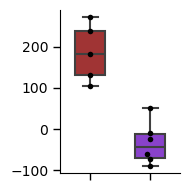

In [17]:
# Plot myeloid chemotaxis factors

prog = "myeloid"
# plot for only anti-PD1-treated, IFN-conditioned tumors (+/- Elf3 KO)
subset_labels = [
    'MOC1i + aPD1', 
    'KOi + aPD1'
]

# define color palette
subset_palette = {
    'MOC1i + aPD1': 'firebrick',
    'KOi + aPD1': 'blueviolet'
}

# create a subset AnnData object with only these samples
adata_subset = adata.obs[adata.obs['condition'].isin(subset_labels)]

# create boxplot
plt.figure(figsize=(2, 2))

ax = sns.boxplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    palette=subset_palette,
    fliersize=0, linewidth=1.5,
    width = .5
)

# overlay scatter plot
sns.swarmplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    color="black", size=4
)

# format
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")

ax.tick_params(
    axis='both',
    direction='out',
    length=5,
    width=1,
    colors='black'
)

plt.xticks(np.arange(len(subset_labels)), [''] * len(subset_labels))  # Remove labels, keep ticks
plt.xlabel('')
plt.ylabel("")
plt.tight_layout()

#plt.savefig("myeloid_score_aPD1_subset.png", dpi=600)
plt.show()


In [18]:
group1 = 'MOC1i + aPD1'
group2 = 'KOi + aPD1'

stat, p = ttest_ind(adata_subset[adata_subset["condition"] == group1][prog].dropna(), 
                    adata_subset[adata_subset["condition"] == group2][prog].dropna(), 
                    equal_var=False)
results = []
results.append({
        "Group 1": group1,
        "Group 2": group2,
        "T-statistic": stat,
        "P-value": p,
        "n1": len(adata_subset[adata_subset["condition"] == group1][prog].dropna()),
        "n2": len(adata_subset[adata_subset["condition"] == group2][prog].dropna())
})
               
results_df = pd.DataFrame(results)

results_df

,Group 1,Group 2,T-statistic,P-value,n1,n2
0,MOC1i + aPD1,KOi + aPD1,5.79724,0.000583,5,6


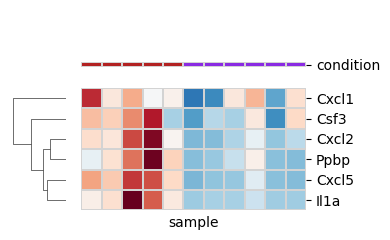

In [19]:
# plot heatmap for select myeloid chemotaxis factors

genes_of_interest = ["Cxcl1", "Cxcl2", "Cxcl5",'Csf3','Il1a','Ppbp']

# plot for only anti-PD1-treated, IFN-conditioned tumors (+/- Elf3 KO)

subset_labels = [
    'MOC1i + aPD1', 
    'KOi + aPD1']

# select color palette
subset_palette = {
    'MOC1i + aPD1': 'firebrick',
    'KOi + aPD1': 'blueviolet'}


# create a subset AnnData object with only these samples

adata_subset = adata[adata.obs['condition'].isin(subset_labels), genes_of_interest]

# convert to DataFrame
expr_df = pd.DataFrame(
    adata_subset.X.toarray() if hasattr(adata_subset.X, "toarray") else adata_subset.X,
    index=adata_subset.obs_names,
    columns=genes_of_interest
)

# specify condition info for sorting and color
expr_df["condition"] = adata_subset.obs["condition"].values
expr_df["condition"] = pd.Categorical(expr_df["condition"], categories=subset_labels, ordered=True)
expr_df = expr_df.sort_values("condition")

# extract matrix for heatmap (samples × genes)
heatmap_data = expr_df.drop(columns="condition")
heatmap_data_z = heatmap_data.apply(zscore, axis=0)

# row colors (top bar) based on condition
row_colors = expr_df["condition"].map(subset_palette)

# plot
sns.clustermap(
    data=heatmap_data_z.T,
    col_colors=row_colors,
    row_cluster=True, col_cluster=False,
    cmap="RdBu_r", center=0,
    xticklabels=False, yticklabels=True,
    linewidths=0.2, linecolor='lightgray',
    figsize=(4, 2.5),
    cbar_pos=None  # ← Proper way to hide color bar in clustermap
)

plt.tight_layout()
#plt.savefig("CXCL_expression_heatmap.png", dpi=600)
plt.show()

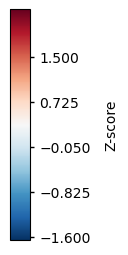

In [20]:
# create colorbar for heatmap
vmin, vmax = heatmap_data_z.min().min(), heatmap_data_z.max().max()
cmap = plt.get_cmap("RdBu_r")
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

# create plot
fig, ax = plt.subplots(figsize=(1, 3)) 
fig.subplots_adjust(left=0.4, right=0.6)  # center colorbar

cb = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, orientation='vertical'
)

cb.set_label("Z-score", color='black', labelpad=10)
cb.ax.tick_params(colors='black', width=1, length=3)

# set ticks
cb.set_ticks(np.linspace(-1.6, 1.5, 5))

# Save or show
#plt.savefig("CXCL_expression_scalebar_only.png", dpi=600, bbox_inches='tight')
plt.show()


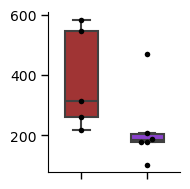

In [21]:
# plot IFN-response score between aPD1-treated, IFN-conditioned tumors
prog = "ICBres"

subset_labels = [
'MOC1i + aPD1',
'KOi + aPD1'
]

subset_palette = {
    'MOC1i + aPD1': 'firebrick',
    'KOi + aPD1': 'blueviolet'
}

# subset only above samples
adata_subset = adata.obs[adata.obs['condition'].isin(subset_labels)]

# plot boxplot
plt.figure(figsize=(2, 2))

ax = sns.boxplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    palette=subset_palette,
    fliersize=0, linewidth=1.5, width=.5
)

# overlay scatter plot
sns.swarmplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    color="black", size=4
)

# format
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")

ax.tick_params(
    axis='both',
    direction='out',
    length=5,
    width=1,
    colors='black'
)

plt.xticks(np.arange(len(subset_labels)), [''] * len(subset_labels))  # Remove labels, keep ticks
plt.xlabel('')
plt.ylabel("")
plt.tight_layout()
#plt.savefig("ICBres_score_aPD1_subset.png", dpi=600)
plt.show()

In [22]:
# perform MWU test
results_df = pd.DataFrame([
    {
        "Group 1": g1,
        "Group 2": g2,
        "U-statistic": (stat := mannwhitneyu(
            (v1 := adata_subset[adata_subset["condition"] == g1][prog].dropna()),
            (v2 := adata_subset[adata_subset["condition"] == g2][prog].dropna()),
            alternative='two-sided'
        ))[0],
        "P-value": stat[1],
        "n1": len(v1),
        "n2": len(v2)
    }
    for g1, g2 in combinations(subset_labels, 2)
])

results_df

,Group 1,Group 2,U-statistic,P-value,n1,n2
0,MOC1i + aPD1,KOi + aPD1,27.0,0.030303,5,6


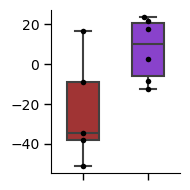

In [23]:
# plot IFN-response score between aPD1-treated, IFN-conditioned tumors
prog = "IFNresp"

subset_labels = [
'MOC1i + aPD1',
'KOi + aPD1'
]

subset_palette = {
    'MOC1i + aPD1': 'firebrick',
    'KOi + aPD1': 'blueviolet'
}

# subset only above samples
adata_subset = adata.obs[adata.obs['condition'].isin(subset_labels)]

# plot boxplot
plt.figure(figsize=(2, 2))

ax = sns.boxplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    palette=subset_palette,
    fliersize=0, linewidth=1.5, width=.5
)

# overlay scatter plot
sns.swarmplot(
    x="condition", y=prog, data=adata_subset,
    order=subset_labels,
    color="black", size=4
)

# format
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color("black")
ax.spines['bottom'].set_color("black")

ax.tick_params(
    axis='both',
    direction='out',
    length=5,
    width=1,
    colors='black'
)

plt.xticks(np.arange(len(subset_labels)), [''] * len(subset_labels))  # Remove labels, keep ticks
plt.xlabel('')
plt.ylabel("")
plt.tight_layout()

#plt.savefig("IFNresp_score_aPD1_subset.png", dpi=600)
plt.show()

In [24]:
# perform MWU test
results_df = pd.DataFrame([
    {
        "Group 1": g1,
        "Group 2": g2,
        "U-statistic": (stat := mannwhitneyu(
            (v1 := adata_subset[adata_subset["condition"] == g1][prog].dropna()),
            (v2 := adata_subset[adata_subset["condition"] == g2][prog].dropna()),
            alternative='two-sided'
        ))[0],
        "P-value": stat[1],
        "n1": len(v1),
        "n2": len(v2)
    }
    for g1, g2 in combinations(subset_labels, 2)
])

results_df

,Group 1,Group 2,U-statistic,P-value,n1,n2
0,MOC1i + aPD1,KOi + aPD1,4.0,0.051948,5,6
